In [25]:
import numpy as np
from matplotlib import pyplot as plt
from rescomp import lorenz_equ, lorenz_deriv
from scipy import integrate
from math import floor

In [7]:
plt.rcParams["figure.figsize"] = [10, 5]
TOL = 5

# Integration Accuracy Duration Benchmark

This notebook explores how long numerical integration can accurately reproduce the Lorenz equations when the integration process is stopped and then restarted. There appear to be numerical errors that prevent the solver from producing the same orbit when it is stopped in the middle and then restarted.

1. Generate a random initial condition
2. Integrate the Lorenz equations from t=0 to t=60 to obtain a solution, $u$
3. Using $u(40)$ as an initial condition, integrate from $t=40$ to $t=60$ to obtain $v$
4. Determine how long $||u_i - v_i||_2 < 5$

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


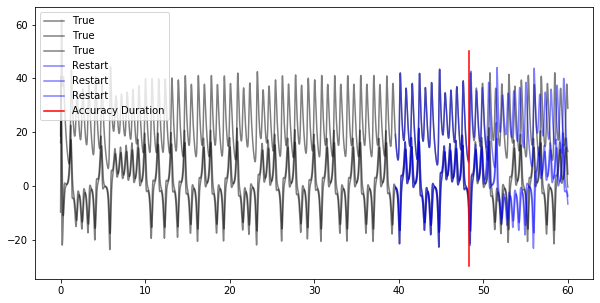

Accuracy duration: 8711


In [3]:
def random_lorenz_x0():
    """ Random initial condition for lorenz equations """
    return  20*(2*np.random.rand(3) - 1)

def how_long_accurate(u, pre, tol=1):
    """ Find the first i such that ||u_i - pre_i||_2 > tol """
    for i in range(u.shape[1]):
        dist = np.sum((u[:,i] - pre[:,i])**2)**.5
        if dist > tol:
            return i
    return u.shape[1]

x0 = random_lorenz_x0()
tr, ts, u = lorenz_equ(x0, begin=0, end=60, timesteps=60000, train_per=.66)
t = np.hstack((tr, ts))

x0 = u(ts).T[0, :].flatten()
# Start integration at a point in the middle
v = integrate.solve_ivp(lorenz_deriv, (ts[0],ts[-1]), x0, dense_output=True).sol
acc_dur = how_long_accurate(u(ts), v(ts), tol=TOL)
end_line = (acc_dur * np.ones(50) / 1000) + ts[0]
plt.plot(t, u(t).T, c='k', alpha=.5, label="True")
plt.plot(ts, v(ts).T, c='b', alpha=.5, label="Restart")
plt.plot(end_line, np.linspace(-30, 50), c='r', label="Accuracy Duration")
plt.legend()
plt.show()
print(f"Accuracy duration: {acc_dur}")


### Determine the mean accuracy duration for integration

#### 1. Start at last point of the training orbit

In [4]:
n = 2000
acc_durs1 = []
for i in range(n):
    x0 = random_lorenz_x0()
    tr, ts, u = lorenz_equ(x0, begin=0, end=60, timesteps=60000, train_per=.66)
    x0 = u(tr).T[-1, :].flatten()
    v = integrate.solve_ivp(lorenz_deriv, (ts[0],ts[-1]), x0, dense_output=True).sol
    acc_dur = how_long_accurate(u(ts), v(ts), tol=TOL)
    acc_durs1.append(acc_dur)
    
print(f"Integration accuracy duration: {np.mean(acc_durs1)} (Mean of {n})")

Integration accuracy duration: 4506.4585 (Mean of 2000)


#### 2. Start at the first point of the testing orbit

In [5]:
acc_durs2 = []
for i in range(n):
    x0 = random_lorenz_x0()
    tr, ts, u = lorenz_equ(x0, begin=0, end=60, timesteps=60000, train_per=.66)
    x0 = u(ts).T[0, :].flatten()
    v = integrate.solve_ivp(lorenz_deriv, (ts[0],ts[-1]), x0, dense_output=True).sol
    acc_dur = how_long_accurate(u(ts), v(ts), tol=TOL)
    acc_durs2.append(acc_dur)
    
print(f"Integration accuracy duration: {np.mean(acc_durs2)} (Mean of {n})")

Integration accuracy duration: 4510.4585 (Mean of 2000)


### Rolling Integration
Integrate the ODE one timestep at a time until it diverges from the true solution.
(Unfortunately, this takes much longer to run.)

In [17]:
def rolling_dur():
    """ Integrate the ODE one timestep at a time until it diverges from the true solution """
    x0 = random_lorenz_x0()
    tr, ts, u = lorenz_equ(x0, begin=0, end=60, timesteps=60000, train_per=.66)

    i = 0
    x0 = u(ts[0]).flatten()
    dist = np.sum((u(ts[i]).flatten() - x0)**2)**.5
    
    while dist < TOL:
        v = integrate.solve_ivp(lorenz_deriv, (ts[i],ts[i+1]), x0, dense_output=True).sol
        i += 1
        x0 = v(ts[i])
        dist = np.sum((u(ts[i]).flatten() - x0)**2)**.5
    return i

acc_durs3 = [None for i in range(n)]
for i in range(n):
    acc_durs3[i] = rolling_dur()
    
print(f"Integration accuracy duration: {np.mean(acc_durs3)} (Mean of {n})")

Integration accuracy duration: 4168.235 (Mean of 2000)


### Use `odeint` instead of `solve_ivp`

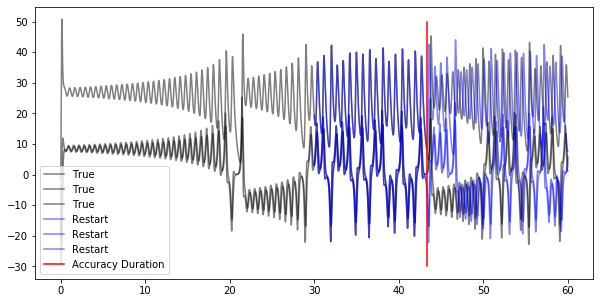

Accuracy duration: 13284


In [35]:
n = 2000
begin=0
end=60
timesteps=60000
train_per=.5
clip = 0
x0 = random_lorenz_x0()
t = np.linspace(begin,end,timesteps)
clipped_start = floor(timesteps * clip / (end - begin))
n_train = floor(clipped_start + train_per * (end - clip) / (end - begin) * timesteps)
tr = t[clipped_start:n_train]
ts = t[n_train:]
u = integrate.odeint(lorenz_dt, x0, t).T
x0 = u[:, n_train].flatten()
v = integrate.odeint(lorenz_dt, x0, ts).T
acc_dur = how_long_accurate(u[:, n_train:], v, tol=TOL)
end_line = (acc_dur * np.ones(50) / 1000) + ts[0]
plt.plot(t, u.T, c='k', alpha=.5, label="True")
plt.plot(ts, v.T, c='b', alpha=.5, label="Restart")
plt.plot(end_line, np.linspace(-30, 50), c='r', label="Accuracy Duration")
plt.legend()
plt.show()
print(f"Accuracy duration: {acc_dur}")

    

In [36]:
def lorenz_dt(X, t0):
    X = tuple(x for x in X)
    return np.array(lorenz_deriv(t0, X))

n = 2000
begin=0
end=60
timesteps=60000
train_per=.5
clip = 0
acc_durs1 = []
for i in range(n):
    x0 = random_lorenz_x0()
    t = np.linspace(begin,end,timesteps)
    clipped_start = floor(timesteps * clip / (end - begin))
    n_train = floor(clipped_start + train_per * (end - clip) / (end - begin) * timesteps)
    tr = t[clipped_start:n_train]
    ts = t[n_train:]
    u = integrate.odeint(lorenz_dt, x0, t).T
    x0 = u[:, n_train].flatten()
    v = integrate.odeint(lorenz_dt, x0, ts).T
    acc_dur = how_long_accurate(u[:, n_train:], v, tol=TOL)
    acc_durs1.append(acc_dur)
    
print(f"Integration accuracy duration: {np.mean(acc_durs1)} (Mean of {n})")

Integration accuracy duration: 15722.791 (Mean of 2000)


### Rolling Integration
Integrate the ODE one timestep at a time until it diverges from the true solution. (Also slow)

In [53]:
def rolling_dur():
    """ Integrate the ODE one timestep at a time until it diverges from the true solution """
    x0 = random_lorenz_x0()
    begin=0
    end=60
    timesteps=60000
    train_per=.5
    clip = 0
    acc_durs1 = []
    t = np.linspace(begin,end,timesteps)
    clipped_start = floor(timesteps * clip / (end - begin))
    n_train = floor(clipped_start + train_per * (end - clip) / (end - begin) * timesteps)
    tr = t[clipped_start:n_train]
    ts = t[n_train:]
    u = integrate.odeint(lorenz_dt, x0, t).T

    i = 0
    x0 = u[:, n_train].flatten()
    dist = np.sum((u[:, n_train].flatten() - x0)**2)**.5
    
    while dist < TOL:
        v = integrate.odeint(lorenz_dt, x0, ts[i:i+2]).T
        i += 1
        x0 = v[:, 1].flatten()
        dist = np.sum((u[:, n_train + i].flatten() - x0)**2)**.5
    return i

n = 2000
acc_durs3 = [None for i in range(n)]
for i in range(n):
    acc_durs3[i] = rolling_dur()
    
print(f"Integration accuracy duration: {np.mean(acc_durs3)} (Mean of {n})")

Integration accuracy duration: 9650.664 (Mean of 2000)
